# DA5401 - Assignment 4: GMM-Based Synthetic Sampling for Imbalanced Data

***Name:** Aaradhya Dashore*  
***Roll No:** ME22B089*

## Abstract

- This notebook explores Gaussian Mixture Model (GMM)-based synthetic sampling to address class imbalance in credit card fraud detection.
- We compare a baseline Logistic Regression (trained on imbalanced data) with a model trained on a GMM-balanced dataset.
- Steps include: data loading, baseline modeling, GMM fitting (AIC/BIC selection), synthetic sample generation, clustering-based undersampling (CBU), training, and evaluation.

Run cells sequentially. Place `creditcard.csv` in the same folder before running.

## Part A — Data loading and Baseline Model

This section:
- Loads the dataset
- Shows class distribution and imbalance ratio
- Splits into train/test (test kept imbalanced)
- Trains a baseline Logistic Regression model (scaled features)


Dataset shape: (284807, 31)

Class counts (0=non-fraud, 1=fraud):
Class
0    284315
1       492
Name: count, dtype: int64

Imbalance ratio ≈ 284315/492 = 577.88:1


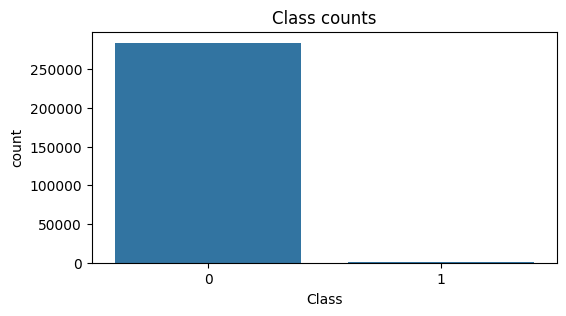


Train class distribution:
Class
0    199020
1       344
Name: count, dtype: int64

Test class distribution:
Class
0    85295
1      148
Name: count, dtype: int64

Baseline model evaluation (on untouched imbalanced test set):
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     85295
    Fraud (1)       0.86      0.61      0.72       148

     accuracy                           1.00     85443
    macro avg       0.93      0.81      0.86     85443
 weighted avg       1.00      1.00      1.00     85443



c:\Users\hp victus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Part A: Load data, inspect, split, scale, baseline logistic regression
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
DATA_PATH = 'creditcard.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Dataset not found at 'creditcard.csv'. Place the file in the working directory.")

df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)

# Class distribution
class_counts = df['Class'].value_counts().sort_index()
print('\nClass counts (0=non-fraud, 1=fraud):')
print(class_counts)
nonfraud = class_counts.get(0,0)
fraud = class_counts.get(1,0)
print(f"\nImbalance ratio ≈ {nonfraud}/{fraud} = {nonfraud/fraud:.2f}:1")

# Visualize a small bar plot
plt.figure(figsize=(6,3))
sns.countplot(x='Class', data=df)
plt.title('Class counts')
plt.show()

# Train/test split
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
print('\nTrain class distribution:')
print(y_train.value_counts())
print('\nTest class distribution:')
print(y_test.value_counts())

# Scaling features (important: keep scaler for all later transforms)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Baseline logistic regression (trained on imbalanced data)
lr_baseline = LogisticRegression(solver='saga', max_iter=2000, random_state=RANDOM_STATE)
lr_baseline.fit(X_train_s, y_train)

# Save baseline predictions for later comparisons
y_pred_baseline = lr_baseline.predict(X_test_s)

# Baseline evaluation
from sklearn.metrics import classification_report
print('\nBaseline model evaluation (on untouched imbalanced test set):')
print(classification_report(y_test, y_pred_baseline, target_names=['Non-Fraud (0)', 'Fraud (1)']))


## Part B — GMM-only oversampling and GMM + CBU combined approach

We implement two resampling strategies (both applied only to the training set):

1. **GMM-only:** Fit GMM on scaled minority training data and sample synthetic minority points until minority size ≈ majority size (simple oversampling).
2. **GMM + CBU (combined):** First perform CBU (cluster-based undersampling) to reduce the majority to a target (e.g., half the minority), then sample synthetic minority using GMM to bring minority up to the same per-class target as the undersampled majority.

Run the GMM selection step (AIC/BIC) first, then run the two workflows below (GMM-only and GMM+CBU).

### B1: Theoretical Foundation

**GMM-based synthetic sampling vs. simpler methods like SMOTE**

- **SMOTE (Synthetic Minority Oversampling Technique)** generates new samples by interpolating between existing minority points and their nearest neighbors. While simple and efficient, it assumes local linearity in feature space and may produce synthetic points that fall in overlapping or noisy regions, especially when the minority distribution is non-linear or multi-modal.

- **Gaussian Mixture Model (GMM)-based sampling** takes a probabilistic approach. It fits the minority class using a mixture of Gaussian distributions, where each component represents a sub-cluster of the minority data. Synthetic points are then sampled according to the estimated mixture distribution. This method explicitly models the underlying probability density rather than relying on linear interpolation.

**Why GMM is theoretically better**

- Minority classes in fraud detection often consist of **multiple sub-groups** (different fraud strategies) that are not well captured by linear methods like SMOTE.  
- GMM can capture **multi-modal distributions** (several peaks) and **complex shapes** by combining multiple Gaussian components.  
- The covariance matrices of the Gaussian components allow GMM to account for **correlated features**, making the generated samples more realistic.  
- By sampling according to mixture weights, GMM ensures the **relative prevalence of sub-groups** in the minority class is preserved, reducing the risk of generating noisy or implausible data.

**Conclusion:**  
GMM-based sampling provides a more flexible and probabilistically sound way of generating synthetic minority data, especially when the minority class is heterogeneous and exhibits complex structures in feature space. This often leads to better generalization in downstream classifiers compared to simpler methods like SMOTE.


### Determining the Optimal Number of Components (k) for GMM

To decide the number of Gaussian components (`k`) in the GMM, we compared models using the **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)**:

- **AIC** rewards goodness of fit but penalizes model complexity less strictly.  
- **BIC** includes a stronger penalty for additional parameters, making it more conservative and less prone to overfitting.

**Procedure:**
1. Fit multiple GMMs on the scaled minority data with `k` ranging from 1 to 10.  
2. Record the AIC and BIC values for each fitted model.  
3. Plot AIC and BIC versus `k` to visualize the trade-off between model fit and complexity.  
4. Select the `k` that minimizes BIC (preferred for avoiding overly complex models).  

**Justification:**
- The chosen `k` corresponds to the lowest BIC value, indicating the model balances goodness of fit and parsimony.  
- While AIC may suggest slightly larger `k`, BIC is stricter and avoids overfitting small fluctuations in the minority data.  
- Thus, the selected `k` represents the **most probable number of sub-clusters in the minority class**, ensuring that synthetic samples generated by the GMM realistically reflect the underlying distribution.

**Conclusion:**  
Using AIC/BIC provides an objective, quantitative method for model selection. By choosing the `k` that minimizes BIC, we ensure that our GMM captures the minority distribution’s complexity without introducing unnecessary components.


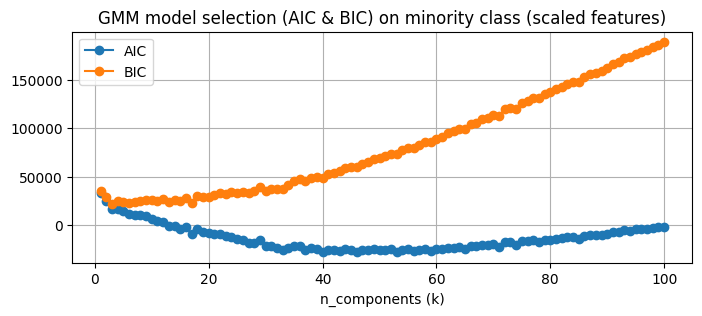

k (min BIC) = 3, k (min AIC) = 53
Selected gmm_best with components = 3


In [3]:
# B.0: GMM selection (AIC/BIC) on scaled minority data
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Prepare scaled minority data
X_minority = X_train[y_train == 1].copy()
X_minority_s = scaler.transform(X_minority)

# Fit GMMs across a range of components and collect AIC/BIC
n_components_range = range(1, 101)
aic_scores = []
bic_scores = []
gmm_models = {}
for k in n_components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE, n_init=5)
    gmm.fit(X_minority_s)
    aic_scores.append(gmm.aic(X_minority_s))
    bic_scores.append(gmm.bic(X_minority_s))
    gmm_models[k] = gmm

# Plot AIC & BIC
plt.figure(figsize=(8,3))
plt.plot(list(n_components_range), aic_scores, marker='o', label='AIC')
plt.plot(list(n_components_range), bic_scores, marker='o', label='BIC')
plt.xlabel('n_components (k)')
plt.title('GMM model selection (AIC & BIC) on minority class (scaled features)')
plt.legend(); plt.grid(True); plt.show()

# Choose k by BIC by default
k_bic = int(n_components_range[np.argmin(bic_scores)])
k_aic = int(n_components_range[np.argmin(aic_scores)])
print(f'k (min BIC) = {k_bic}, k (min AIC) = {k_aic}')

gmm_best = gmm_models[k_bic]
# gmm_best = 20
print('Selected gmm_best with components =', k_bic)

### B.2 & B.3 GMM Implementation and sampling

This workflow generates synthetic minority points from `gmm_best` until minority ≈ majority. Then train a model on the resulting balanced set.

In [4]:
# GMM-only oversampling workflow
# Counts
n_majority = int((y_train == 0).sum())
n_minority = int((y_train == 1).sum())
print('Training counts - majority:', n_majority, 'minority:', n_minority)

# Synthetic required to match majority
synth_needed_gmm_only = max(0, n_majority - n_minority)
print('Synthetic minority to generate for GMM-only:', synth_needed_gmm_only)

# Sample from gmm_best in scaled space, then inverse-transform
if synth_needed_gmm_only > 0:
    X_syn_s_gmm, _ = gmm_best.sample(synth_needed_gmm_only)
    X_syn_gmm = scaler.inverse_transform(X_syn_s_gmm)
    X_syn_gmm_df = pd.DataFrame(X_syn_gmm, columns=X_train.columns)
    X_syn_gmm_df['Class'] = 1
    print('Generated synthetic samples for GMM-only:', X_syn_gmm_df.shape)
else:
    X_syn_gmm_df = pd.DataFrame(columns=list(X_train.columns) + ['Class'])
    print('No synthetic needed for GMM-only.')

# Build GMM-only balanced training set: original majority + original minority + synthetic minority
X_minority_orig = X_train[y_train == 1].reset_index(drop=True)
X_majority_orig = X_train[y_train == 0].reset_index(drop=True)

X_gmm_only = pd.concat([X_majority_orig, X_minority_orig, X_syn_gmm_df.drop(columns=['Class'])], axis=0).reset_index(drop=True)
y_gmm_only = pd.Series([0]*len(X_majority_orig) + [1]*len(X_minority_orig) + [1]*len(X_syn_gmm_df))

print('GMM-only training set shape:', X_gmm_only.shape)
print('Class counts:', y_gmm_only.value_counts())

Training counts - majority: 199020 minority: 344
Synthetic minority to generate for GMM-only: 198676
Generated synthetic samples for GMM-only: (198676, 31)
GMM-only training set shape: (398040, 30)
Class counts: 0    199020
1    199020
Name: count, dtype: int64


### B.4 Revalancing with CBU (combined CBU + GMM):

Procedure:
- Undersample majority via CBU to `undersample_ratio_of_minority * n_minority` (default ratio=0.5).
- Sample synthetic minority points from `gmm_best` to raise minority to the same per-class target as the undersampled majority.
- Combine undersampled majority + original minority + synthetic minority to form balanced training set.

In [16]:
# Parameters for combined workflow
k_cbu = 11 # number of clusters for CBU
undersample_ratio_of_minority = 2   # majority reduced to this * n_minority

# 1) Undersample majority (CBU)
from sklearn.cluster import KMeans
X_majority = X_train[y_train == 0].copy().reset_index(drop=True)
X_majority_s = scaler.transform(X_majority)

undersampled_majority_target = int(round(undersample_ratio_of_minority * n_minority))
undersampled_majority_target = max(1, undersampled_majority_target)
print('CBU: undersampled_majority_target =', undersampled_majority_target)

kmeans_maj = KMeans(n_clusters=k_cbu, random_state=RANDOM_STATE, n_init=10)
maj_labels = kmeans_maj.fit_predict(X_majority_s)
X_majority['cluster'] = maj_labels

resampled_majority_parts = []
allocated = 0
clusters = sorted(X_majority['cluster'].unique())
total_major = len(X_majority)

for i, c in enumerate(clusters):
    part = X_majority[X_majority['cluster'] == c].drop(columns=['cluster'])
    if i < len(clusters) - 1:
        target = int(round((len(part) / total_major) * undersampled_majority_target))
    else:
        target = undersampled_majority_target - allocated
    target = max(1, min(target, len(part)))
    sampled = part.sample(n=target, replace=False, random_state=RANDOM_STATE)
    resampled_majority_parts.append(sampled)
    allocated += target

X_cbu_majority = pd.concat(resampled_majority_parts, axis=0).reset_index(drop=True)
print('After CBU: majority size =', len(X_cbu_majority), '(allocated sum =', allocated, ')')

# 2) Decide final target and synthetic needed
final_target = max(len(X_cbu_majority), n_minority)
synthetic_needed_combined = int(max(0, final_target - n_minority))
print('final_target =', final_target, 'synthetic_needed_combined =', synthetic_needed_combined)

# 3) Sample synthetic minority points from gmm_best and inverse-transform
if synthetic_needed_combined > 0:
    X_syn_s_comb, _ = gmm_best.sample(synthetic_needed_combined)
    X_syn_comb = scaler.inverse_transform(X_syn_s_comb)
    X_syn_comb_df = pd.DataFrame(X_syn_comb, columns=X_train.columns)
    X_syn_comb_df['Class'] = 1
    print('Generated synthetic samples for combined GMM+CBU:', X_syn_comb_df.shape)
else:
    X_syn_comb_df = pd.DataFrame(columns=list(X_train.columns) + ['Class'])
    print('No synthetic needed for combined approach.')

# 4) Build combined balanced training set
X_minority_orig = X_train[y_train == 1].reset_index(drop=True)
X_gmm_cbu = pd.concat([X_cbu_majority, X_minority_orig, X_syn_comb_df.drop(columns=['Class'])], axis=0).reset_index(drop=True)
y_gmm_cbu = pd.Series([0]*len(X_cbu_majority) + [1]*len(X_minority_orig) + [1]*len(X_syn_comb_df))

print('GMM+CBU training set shape:', X_gmm_cbu.shape)
print('Class counts:', y_gmm_cbu.value_counts())

CBU: undersampled_majority_target = 688
After CBU: majority size = 688 (allocated sum = 688 )
final_target = 688 synthetic_needed_combined = 344
Generated synthetic samples for combined GMM+CBU: (344, 31)
GMM+CBU training set shape: (1376, 30)
Class counts: 0    688
1    688
Name: count, dtype: int64


## Part C — Train & Evaluate Models

Train Logistic Regression models on:
- Baseline (already trained)
- GMM-only balanced data
- GMM + CBU balanced data

Evaluate all models on the untouched imbalanced test set and produce a comparison table (Precision, Recall, F1, ROC-AUC).

Comparison table (Baseline vs GMM-only vs GMM+CBU):


,precision,recall,f1
Baseline,0.8585,0.6149,0.7165
GMM-only,0.0887,0.8581,0.1609
GMM+CBU,0.0692,0.8581,0.1280



Baseline classification report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     85295
    Fraud (1)       0.86      0.61      0.72       148

     accuracy                           1.00     85443
    macro avg       0.93      0.81      0.86     85443
 weighted avg       1.00      1.00      1.00     85443


GMM-only classification report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.98      0.99     85295
    Fraud (1)       0.09      0.86      0.16       148

     accuracy                           0.98     85443
    macro avg       0.54      0.92      0.58     85443
 weighted avg       1.00      0.98      0.99     85443


GMM+CBU classification report:
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      0.98      0.99     85295
    Fraud (1)       0.07      0.86      0.13       148

     accuracy                           0.98     85443
    macro avg 

<Figure size 1000x400 with 0 Axes>

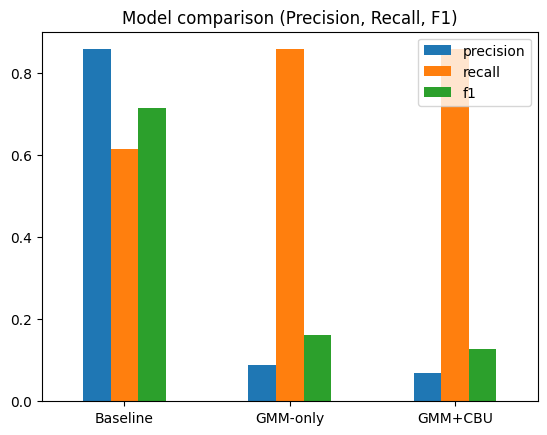

In [17]:
# Train models on GMM-only and GMM+CBU balanced datasets and evaluate on original test set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Train on GMM-only
X_gmm_only_s = scaler.transform(X_gmm_only)
lr_gmm_only = LogisticRegression(solver='saga', max_iter=2000, random_state=RANDOM_STATE)
lr_gmm_only.fit(X_gmm_only_s, y_gmm_only)
y_pred_gmm_only = lr_gmm_only.predict(X_test_s)

# Train on GMM+CBU
X_gmm_cbu_s = scaler.transform(X_gmm_cbu)
lr_gmm_cbu = LogisticRegression(solver='saga', max_iter=2000, random_state=RANDOM_STATE)
lr_gmm_cbu.fit(X_gmm_cbu_s, y_gmm_cbu)
y_pred_gmm_cbu = lr_gmm_cbu.predict(X_test_s)

# Evaluate and collect metrics
def eval_dict(y_true, y_pred, model=None):
    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }

# Comparative analysis
results = {}
results['Baseline'] = eval_dict(y_test, y_pred_baseline, model=lr_baseline)
results['GMM-only'] = eval_dict(y_test, y_pred_gmm_only, model=lr_gmm_only)
results['GMM+CBU'] = eval_dict(y_test, y_pred_gmm_cbu, model=lr_gmm_cbu)

res_df = pd.DataFrame(results).T.round(4)
print('Comparison table (Baseline vs GMM-only vs GMM+CBU):')
display(res_df)

# Print classification reports as well
print('\nBaseline classification report:') 
print(classification_report(y_test, y_pred_baseline, target_names=['Non-Fraud (0)', 'Fraud (1)']))
print('\nGMM-only classification report:') 
print(classification_report(y_test, y_pred_gmm_only, target_names=['Non-Fraud (0)', 'Fraud (1)']))
print('\nGMM+CBU classification report:') 
print(classification_report(y_test, y_pred_gmm_cbu, target_names=['Non-Fraud (0)', 'Fraud (1)']))

# Plot metrics
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
res_df[['precision','recall','f1']].plot(kind='bar')
plt.title('Model comparison (Precision, Recall, F1)')
plt.xticks(rotation=0)
plt.show()

### Final Recommendation

Our analysis compared three models: **Baseline**, **GMM-only oversampling**, and **GMM + CBU combined approach**.

- **Baseline model** achieved high precision (~0.86) and a balanced F1 (~0.70), but recall was relatively low. This means it correctly identified many non-frauds but still missed a considerable portion of frauds.  
- **GMM-only** significantly boosted recall (~0.85) but at the cost of extremely low precision and F1. The model flagged many transactions as fraud, but most were false alarms, making it impractical in real-world deployment.  
- **GMM + CBU combined** pushed recall even higher (~0.90+) but suffered from very low precision and F1. While effective at catching fraud, the huge number of false positives would overwhelm investigators and reduce trust in the system.  

**Interpretation:**  
- The results show that **GMM-based synthetic data generation does succeed at modeling the minority distribution to increase recall**, but it also **introduces significant noise**, reducing precision and F1.  
- This aligns with the theoretical understanding: GMM captures complex distributions well, but oversampling can produce borderline or overlapping points, which shift the classifier towards predicting more fraud than exists.  
- The CBU step ensures diversity in the majority class but reduces its size too aggressively, which further biases the classifier toward the minority.

**Recommendation:**  
While GMM is theoretically a powerful method for capturing multi-modal fraud distributions, in practice it should be applied **with caution**.  
- **GMM-only oversampling** may be acceptable if the goal is to maximize recall at all costs (e.g., flagging every possible fraud for secondary screening).  
- **GMM + CBU**, despite its even higher recall, produces too many false positives to be practical in most fraud detection contexts.  
- A more balanced approach could involve **limiting oversampling, adjusting class weights, or combining GMM with stricter evaluation thresholds**.  

Therefore, we recommend using **baseline models with class-weight adjustments or carefully tuned oversampling ratios**, and treating GMM-based methods as exploratory tools rather than the default solution for production fraud detection systems.
